In [77]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from multiprocessing import Pool
from collections import namedtuple

In [78]:
pool = Pool()
pool

## Reference : A Simulation Study on the Activation of Cardiac CaMKII delta-Isoform and Its Regulation by Phosphatases

Chiba H, Schneider NS, Matsuoka S, Noma A

Biophys J. 2008 Sep 01; 95(5) 2139-2149

DOI: 10.1529/biophysj.107.118505, PMID: 18502812, PMCID: PMC2517018

In [79]:
"""
Reference: 
A Simulation Study on the Activation of Cardiac CaMKIId-Isoform and ItsRegulation by Phosphatases
Chiba et. al
DOI: 10.1529/biophysj.107.118505, PMID: 18502812, PMCID: PMC2517018
"""

def _mm(x, k):
    return x / (x + k)

def _hill(x, k, n):
    return _mm(x**n, k**n)

# Calmodulin model
def cam_sys(camca1, camca2, camca3, camca4, ca, cam_total, k1p, k1m, k2p, k2m, k3p, k3m, k4p, k4m):
    """ Calmodulin model """
    cam = cam_total - camca1 - camca2 - camca3 - camca4
    v1 = k1p * cam * ca - k1m * camca1
    v2 = k2p * camca1 * ca - k2m * camca2 
    v3 = k3p * camca2 * ca - k3m * camca3
    v4 = k4p * camca3 * ca - k4m * camca4
    dcamca1 = v1 - v2
    dcamca2 = v2 - v3
    dcamca3 = v3 - v4
    dcamca4 = v4
    return [dcamca1, dcamca2, dcamca3, dcamca4]

# CaMKII model
def camkii_sys(camkii_camca4, camkii_p_camca4, camkii_p, camca4, ca, camkii_total, atp, pp1, k_a, k_d, k_d_ca, k_d2, k_d_ca2, km_cam, kcat, km_atp, kcat_pp1, km_pp1):
    """ CaMKII model """
    camkii = camkii_total - camkii_camca4 - camkii_p_camca4 - camkii_p
    
    # Association of CaMKII and CaMCa4
    a1 = k_a * camkii * camca4
    # Association of CaMKII-p and CaMCa4
    c2 = k_a * camkii_p * camca4
    
    # Dissociation of CaMKII and CaMCa4
    phi_cam = _hill(ca, km_cam, 3)
    a2 = (k_d * (1 - phi_cam) + k_d_ca * phi_cam) * camkii_camca4
     # Dissociation of CaMKII-p and CaMCa4 (1000x slower)
    c1 = (k_d2 * (1 - phi_cam) + k_d_ca2 * phi_cam) * camkii_p_camca4
    
    # Autophosphorylation of CaMKII subunits
    p = 1 - (camkii / camkii_total)**2
    b1 = kcat * p * _mm(atp, km_atp) * camkii_camca4
    
    # Dephosphorylation by phosphorylase (PP1)
    b2 = kcat_pp1 * pp1 * _mm(camkii_p_camca4, km_pp1)
    d1 = kcat_pp1 * pp1 * _mm(camkii_p, km_pp1)
    
    v1 = a1 - a2
    v2 = b1 - b2
    v3 = c1 - c2
    v4 = d1
    dcamkii_p = v3 - v4
    dcamkii_camca4 = v1 - v2
    dcamkii_p_camca4 = v2 - v3
    return [dcamkii_camca4, dcamkii_p_camca4, dcamkii_p]

def rhs(t, y, cam_total, k1p, k1m, k2p, k2m, k3p, k3m, k4p, k4m, camkii_total, atp, pp1, k_a, k_d, k_d_ca, k_d2, k_d_ca2, km_cam, kcat, km_atp, kcat_pp1, km_pp1):
    camca1, camca2, camca3, camca4, camkii_camca4, camkii_p_camca4, camkii_p, ca = y
    
    v_cam = cam_sys(camca1, camca2, camca3, camca4, ca, cam_total, k1p, k1m, k2p, k2m, k3p, k3m, k4p, k4m)
    v_camkii = camkii_sys(camkii_camca4, camkii_p_camca4, camkii_p, camca4, ca, camkii_total, atp, pp1, k_a, k_d, k_d_ca, k_d2, k_d_ca2, km_cam, kcat, km_atp, kcat_pp1, km_pp1)
    dca = 0
    return v_cam + v_camkii + [dca] # Merge lists


In [85]:
# Reference constants from the original paper
K1 = 2.5
KM1 = KM2 = 0.05
K2 = 88.25
K3 = 12.5
KM3 = KM4 = 1.25
K4 = 250

K_A = 2.1
K_D_ALPHA = 1.4E-4
K_D_DELTA = 0.5 * K_D_ALPHA
K_D_CA_ALPHA = 1.9E-3
K_D_CA_DELTA = 0.5 * K_D_CA_ALPHA
K_D2_ALPHA = K_D_ALPHA * 1e-3
K_D2_DELTA = K_D_DELTA * 1e-3
K_D2_CA_ALPHA = K_D_CA_ALPHA * 1e-3
K_D2_CA_DELTA = K_D_CA_DELTA * 1e-3
KM_CAM = 3E-5
KCAT_0_ALPHA = 1E-5
KCAT_0_DELTA = 6 * KCAT_0_ALPHA
KCAT_30_ALPHA = 30 * KCAT_0_ALPHA
KCAT_30_DELTA = 6 * KCAT_30_ALPHA
KCAT_37_ALPHA = 3 * KCAT_30_ALPHA
KCAT_37_DELTA = 6 * KCAT_37_ALPHA
KM_ATP = 19.1E-3
KCAT_PP1 = 1.72E-3
KM_PP1 = 11.0E-3

# Rate contants we added
# KCAT_COMPLEX1 = 1e-2
# KD_COMPLEX1 = 1e-2
# KCAT_CK_MITO = 1e-2
# KD_CK_MITO = 1e-2

# Substance concentrations
CAM_TOTAL = 6e-3
PP1 = 0.001E-3
CAMKII_TOTAL = 0.1E-3
ATP = 0.1

# Initial conditions
y0 = [0.0, 0.0, 0.0, 0.0] + [0.0, 0.0, 0.0] + [1e-3]

# Other constants
T_END = 1000
DELTA = 0.01

# Params in the ODE
params = { 'cam_total': CAM_TOTAL,
           'k1p': K1,
           'k1m': KM1,
           'k2p': K2,
           'k2m': KM2,
           'k3p': K3,
           'k3m': KM3,
           'k4p': K4,
           'k4m': KM4,
           'camkii_total': CAMKII_TOTAL,
           'atp': ATP,
           'pp1': PP1,
           'k_a': K_A,
           'k_d': K_D_DELTA,
           'k_d_ca': K_D_CA_DELTA,
           'k_d2': K_D2_DELTA,
           'k_d_ca2': K_D2_CA_DELTA,
           'km_cam': KM_CAM,
           'kcat': KCAT_37_DELTA,
           'km_atp': KM_ATP,
           'kcat_pp1': KCAT_PP1,
           'km_pp1': KM_PP1}


# Ranges are 8 orders of magnitude apart, except for some linearly-spaced ones or strictly constant ones
param_ranges = {name: params[name] * np.logspace(-4, 4, num=100) for name in params}
param_ranges['atp'] = np.linspace(0, 1, num=100)
# Calcium ranges (from the author)
ca_concs = np.logspace(-4, -1, num=100)

In [86]:
def _act_camk(sol, params):
    y = sol[0][-1]
    return np.sum(y[4:7]) / params['camkii_total']

def _phosphorylation(sol, params, KM_CAMKII = 0.15):
    """
    Get phosphorylation proportion from active CaMKII level.
    KM = 0.15 from the ORd model
    """
    camkii_act = _act_camk(sol, params)
    return _mm(camkii_act, KM_CAMKII)

# Relative sensitivity analysis

$Sensitivity = (\frac{dP}{P}) / (\frac{dS}{S})$

* In = Parameter(s)

* Out = Unphosphorylated proportion of CaMKII targets (complex I, mitochondrial creatine kinase)

Varying one parameter across 8 orders of magnitude at a time, plus varying calcium concentration, yielding a 2D sensitivity heat map.

In [87]:
t = np.linspace(0, T_END)
y0s = [[0.0] * 7 + [ca] for ca in ca_concs]
ode_params = {'atol': None, 'rtol': None, 'full_output': True, 'tfirst': True}

activated = [_act_camk(odeint(lambda t, y: rhs(t, y, **params), y0, t, **ode_params), params) for y0 in y0s]
activated = np.asarray(activated)
activated
phosphorylated = _mm(activated, 0.15)
phosphorylated

array([8.62561256e-07, 1.14913656e-06, 1.42637715e-06, 1.88029186e-06,
       2.83021890e-06, 3.49610755e-06, 4.66609416e-06, 6.24685663e-06,
       8.60909698e-06, 1.13769865e-05, 1.45737210e-05, 1.80060349e-05,
       2.60494049e-05, 3.34582804e-05, 4.47239639e-05, 5.96913500e-05,
       7.80591032e-05, 1.05226923e-04, 1.37218961e-04, 1.79674520e-04,
       2.37786620e-04, 3.12824142e-04, 4.11735993e-04, 5.41414509e-04,
       7.11751222e-04, 9.33112628e-04, 1.22881707e-03, 1.60625030e-03,
       2.10448840e-03, 2.75435305e-03, 3.60023795e-03, 4.69941176e-03,
       6.12424419e-03, 7.96639902e-03, 1.03407170e-02, 1.33900888e-02,
       1.72903406e-02, 2.22550511e-02, 2.85397375e-02, 3.64442698e-02,
       4.63121664e-02, 5.85253336e-02, 7.34916829e-02, 9.16243234e-02,
       1.13310571e-01, 1.38870984e-01, 1.68510800e-01, 2.02269275e-01,
       2.39975629e-01, 2.81221453e-01, 3.25359354e-01, 3.71534739e-01,
       4.18746720e-01, 4.65932105e-01, 5.12058521e-01, 5.56206427e-01,
      

In [88]:
# Sensitivity for Calcium
y0s_new = [[0.0] * 7 + [ca * (1 + DELTA)] for ca in ca_concs]
activated_new = [_act_camk(odeint(lambda t, y: rhs(t, y, **params), y0, t, **ode_params), params) for y0 in y0s_new]
activated_new = np.asarray(activated_new)
phosphorylated_new = _mm(activated_new, 0.15)
sensitivity = (phosphorylated_new - phosphorylated) / DELTA

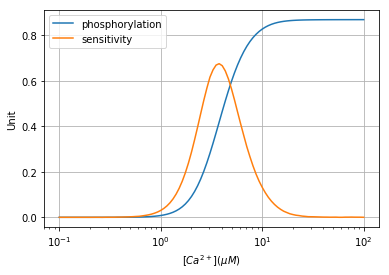

In [89]:
# Recreate Fig. 2, i.e steady-state response of CaMKII to calcium
# dynamic range: Ca = 1~10 μM
plt.figure()
plt.semilogx(ca_concs * 1e3, phosphorylated, label="phosphorylation")
plt.semilogx(ca_concs * 1e3, sensitivity, label="sensitivity")
plt.xlabel(r'$[Ca^{2+}](μM)$')
plt.ylabel('Unit')
plt.legend(loc='best')
plt.grid(True)

A peak of relative sensitivity was noted between 1 $\mu M$ and 10 $\mu M$, in the dynamic range.

In [105]:
def calc_sensitivities(param_original, param_name, param_val, rhs, ca_concs, ode_params, T_END=2000, DELTA=0.01):
    """ Generalized sensitivity map function """
    local_params = param_original.copy()
    local_params[param_name] = param_val
    y0s = [[0.0] * 7 + [ca] for ca in ca_concs]
    phosphorylated = [_phosphorylation(odeint(lambda t, y: rhs(t, y, **local_params), y0, t, **ode_params), local_params, KM_CAMKII=0.15) for y0 in y0s]
    phosphorylated = np.asarray(phosphorylated)
    local_params[param_name] = param_val * (1 + DELTA)
    phosphorylated_new = [_phosphorylation(odeint(lambda t, y: rhs(t, y, **local_params), y0, t, **ode_params), local_params, KM_CAMKII=0.15)]
    phosphorylated_new = np.asarray(phosphorylated_new)
    sensitivities = ( phosphorylated_new - phosphorylated) / DELTA
    return sensitivities

In [106]:
def plot_sensitivities(sensitivities, ca_concs, param_ranges, param_name, log_scale=True):
    """ Plot sensitivity map """
    plt.figure()
    min_sense = np.min(sensitivities)
    max_sense = np.max(sensitivities)
    sense_range = max(abs(min_sense), abs(max_sense))
    plt.pcolormesh(ca_concs * 1e3, param_ranges[param_name], sensitivities, cmap=plt.cm.bwr, vmax=sense_range, vmin=-sense_range)
    plt.xlabel(r'$[Ca^{2+}]( \mu M )$')
    plt.xscale('log')
    if log_scale:
        plt.yscale('log')
    plt.ylabel(param_name.upper())
    return plt.colorbar()

The code was running on Python 3.7 in the Jupyter notebook on a workstation with dual Xeon E5-2620 CPUs.

In [107]:
# Generator of arguments
args = {name: [(params, name, param_val, rhs, ca_concs, ode_params, 1500, 0.01) for param_val in param_ranges[name]] for name in params}

In [108]:
# Multiprocessing (using all CPU cores)
pool = Pool()
param_sensitivities = {}
for name in params:
    param_sensitivities[name] = np.array(pool.starmap(calc_sensitivities, args[name])).reshape(-1, ca_concs.shape[0])
    print(name, 'is completed.')
pool.close()
print('Finished')

cam_total is completed.
k1p is completed.
k1m is completed.
k2p is completed.
k2m is completed.
k3p is completed.
k3m is completed.
k4p is completed.
k4m is completed.
camkii_total is completed.
atp is completed.
pp1 is completed.
k_a is completed.
k_d is completed.
k_d_ca is completed.
k_d2 is completed.
k_d_ca2 is completed.
km_cam is completed.
kcat is completed.
km_atp is completed.
kcat_pp1 is completed.
km_pp1 is completed.
Finished


In [109]:
param_sensitivities['atp']

array([[  0.79587019,   0.79584153,   0.79581381, ..., -85.20973482,
        -85.2202654 , -85.22961256],
       [  0.79615379,   0.79612514,   0.79609741, ..., -85.92864914,
        -85.93249588, -85.93570273],
       [  0.79629082,   0.79626216,   0.79623443, ..., -86.038116  ,
        -86.04096266, -86.04270242],
       ...,
       [  0.79666861,   0.79663996,   0.79661223, ..., -86.13592892,
        -86.13668922, -86.13737861],
       [  0.79666877,   0.79664011,   0.79661239, ..., -86.13594358,
        -86.13670355, -86.1373926 ],
       [  0.79666892,   0.79664026,   0.79661254, ..., -86.13595795,
        -86.13671759, -86.13740631]])

/home/sosiristseng/miniconda3/envs/sci/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


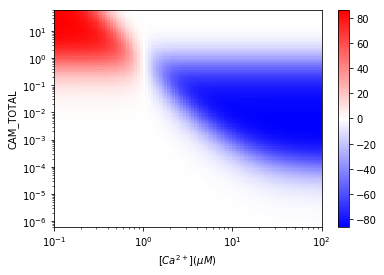

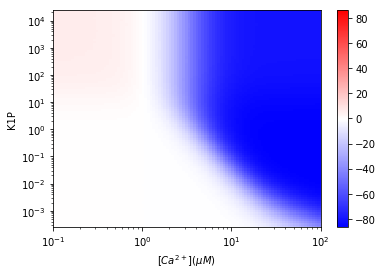

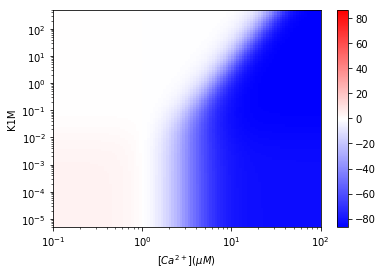

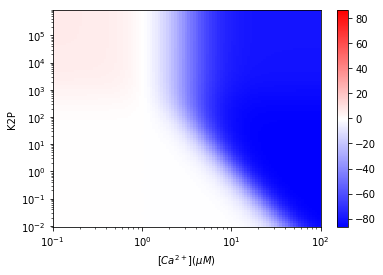

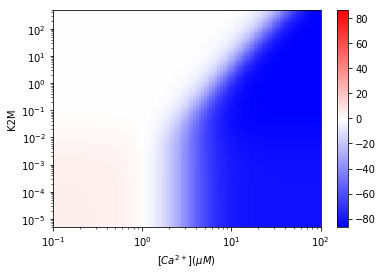

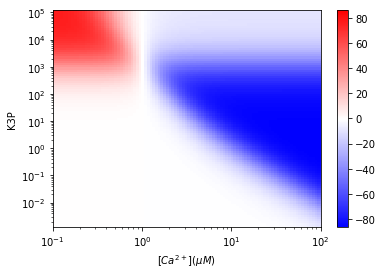

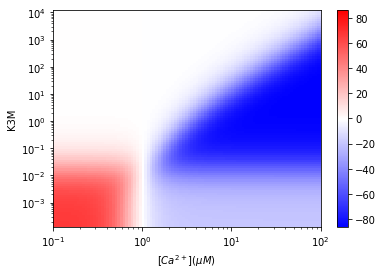

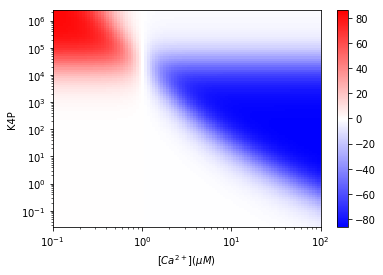

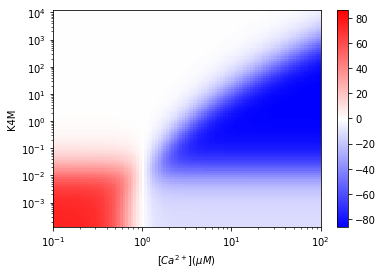

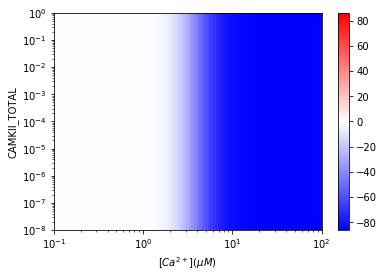

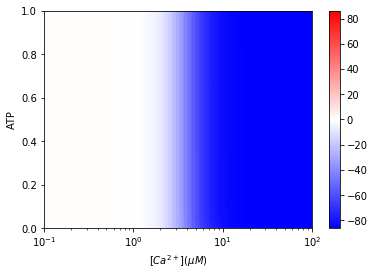

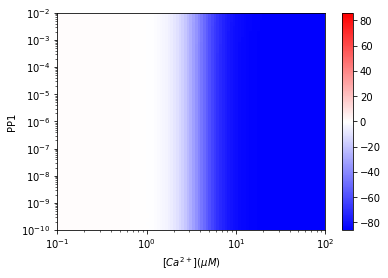

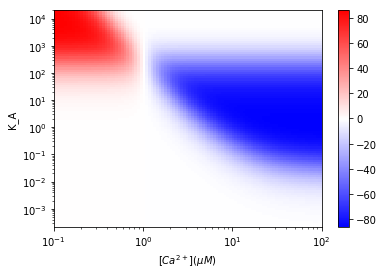

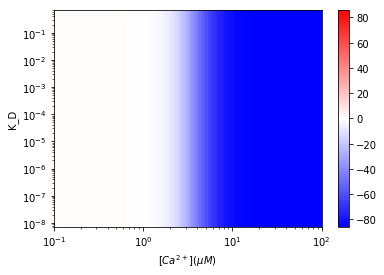

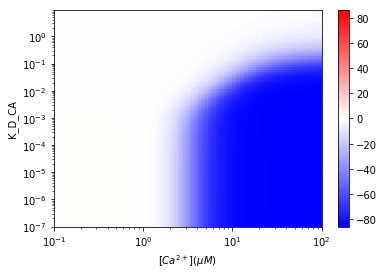

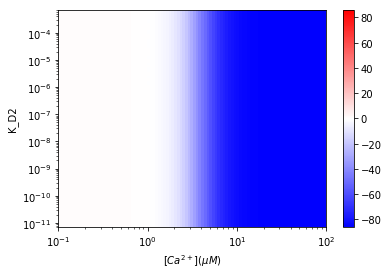

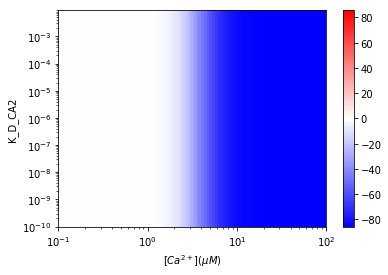

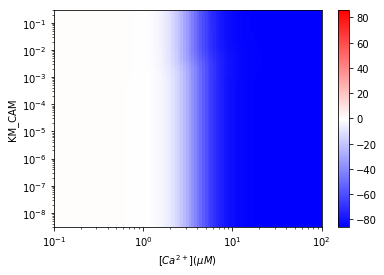

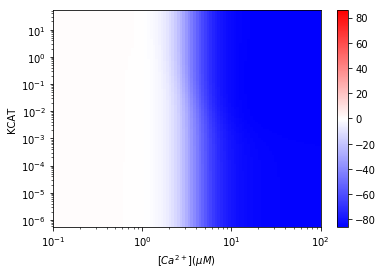

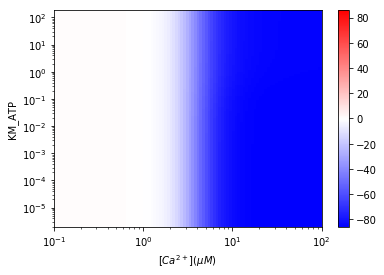

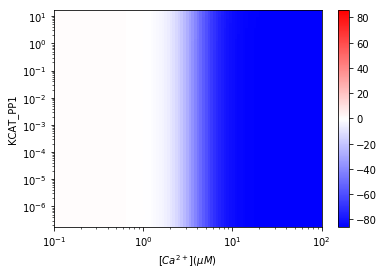

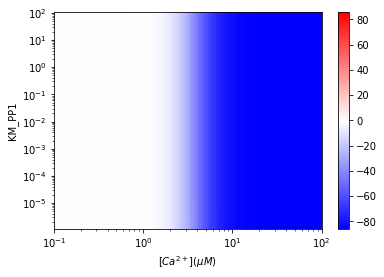

In [110]:
for name in param_sensitivities:
    plot_sensitivities(param_sensitivities[name], ca_concs, param_ranges, name, name not in ('atp'))

In [111]:
# Disable C1 => K_DISSO2 = K_DISSO_CA2 = 0
# Params for the model
params_new = { 'cam_total': CAM_TOTAL,
           'k1p': K1,
           'k1m': KM1,
           'k2p': K2,
           'k2m': KM2,
           'k3p': K3,
           'k3m': KM3,
           'k4p': K4,
           'k4m': KM4,
           'camkii_total': CAMKII_TOTAL,
           'atp': ATP,
           'pp1': PP1,
           'k_a': K_A,
           'k_d': K_D_DELTA,
           'k_d_ca': K_D_CA_DELTA,
           'k_d2': 0.0,
           'k_d_ca2': 0.0,
           'km_cam': KM_CAM,
           'kcat': KCAT_37_DELTA,
           'km_atp': KM_ATP,
           'kcat_pp1': KCAT_PP1,
           'km_pp1': KM_PP1}

# Generator of arguments
args = {name: [(params_new, name, param_val, rhs, ca_concs, ode_params, 1500, 0.01) for param_val in param_ranges[name]] for name in params if (name != 'k_d2' or name != 'k_d_ca2')}

In [112]:
# Multiprocessing (using all CPU cores)
pool = Pool()
param_sensitivities = {}
for name in params:
    param_sensitivities[name] = np.array(pool.starmap(calc_sensitivities, args[name])).reshape(-1, ca_concs.shape[0])
    print(name, 'is completed.')
pool.close()
print('Finished')

cam_total is completed.
k1p is completed.
k1m is completed.
k2p is completed.
k2m is completed.
k3p is completed.
k3m is completed.
k4p is completed.
k4m is completed.
camkii_total is completed.
atp is completed.
pp1 is completed.
k_a is completed.
k_d is completed.
k_d_ca is completed.
k_d2 is completed.
k_d_ca2 is completed.
km_cam is completed.
kcat is completed.
km_atp is completed.
kcat_pp1 is completed.
km_pp1 is completed.
Finished


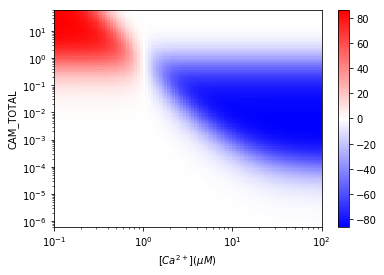

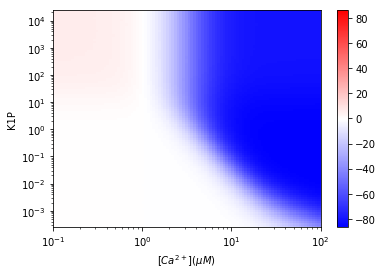

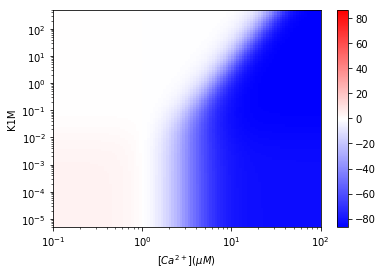

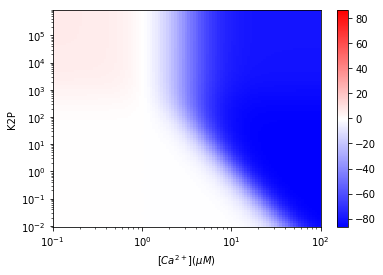

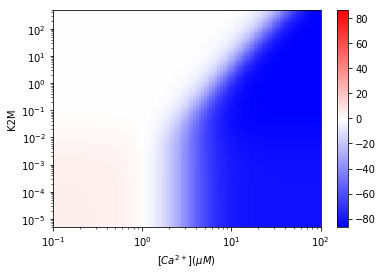

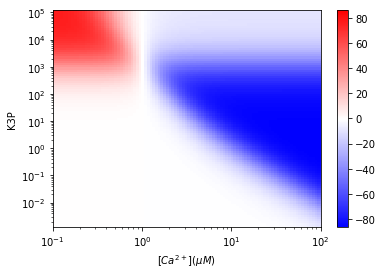

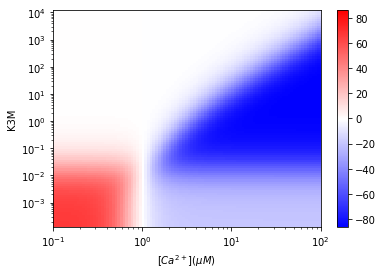

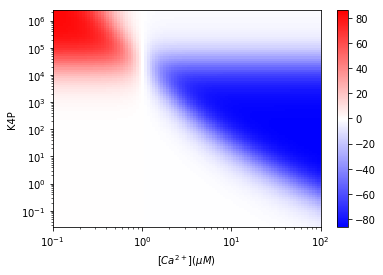

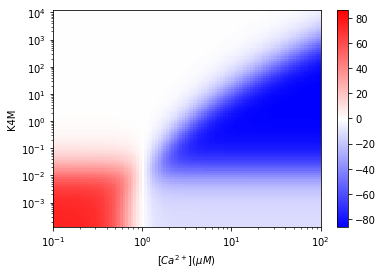

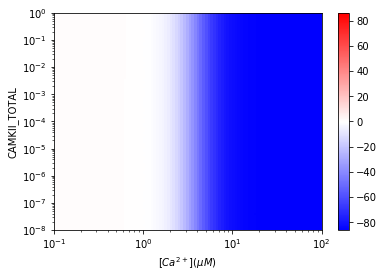

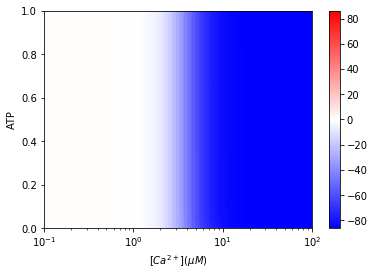

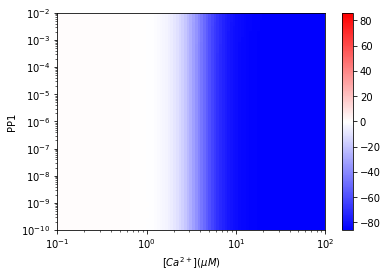

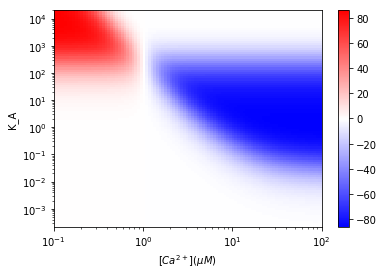

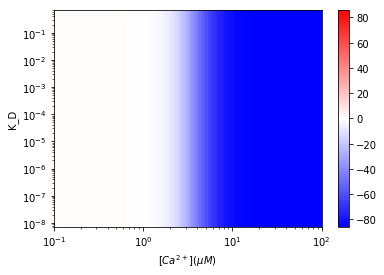

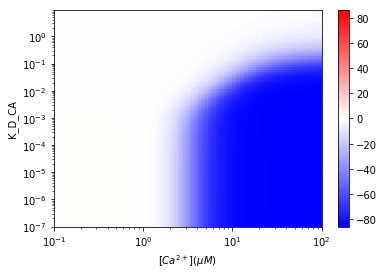

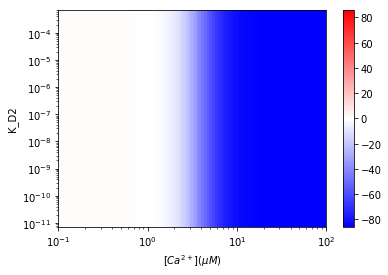

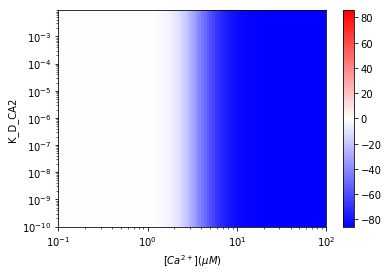

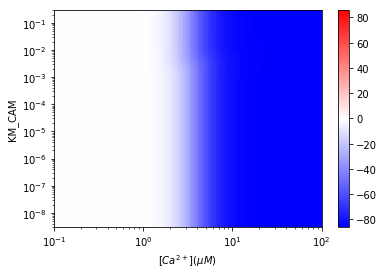

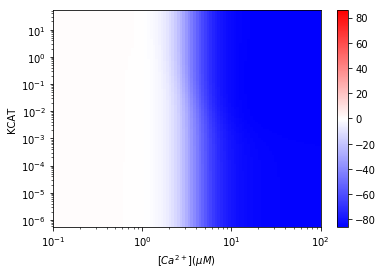

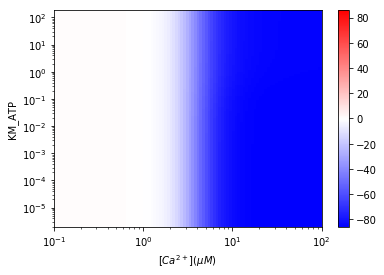

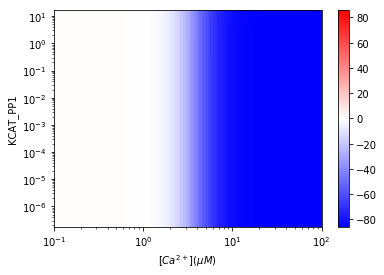

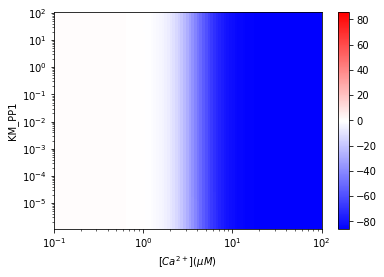

In [113]:
# Plot sensitivities
for name in param_sensitivities:
    plot_sensitivities(param_sensitivities[name], ca_concs, param_ranges, name, name not in ('atp'))